In [1]:
%pip install --upgrade librosa
%pip install --upgrade numba

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obspy
import sys
import os
from scipy import stats,signal
import librosa
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Getting the data

In [4]:
os.chdir('data')
orca_df = pd.read_csv("orca_data.csv")
noise_df = pd.read_csv("noise_data.csv")

orca_df = orca_df.sample(n=len(orca_df)) # shape = (97, 3) whole // 20
noise_df = noise_df.sample(n=len(noise_df)) # shape = (107, 3) whole // 3
print(orca_df.shape)
print(noise_df.shape)

(3887, 3)
(17934, 3)


In [5]:
noise_df

,wav_filename,start_time_s,end_time_s
6967,rpi-port-townsend_2020_09_08_14_39_00.wav,43.000000,44.000000
7002,rpi-port-townsend_2020_09_08_14_40_00.wav,19.000000,20.000000
5800,660160005.wav,24.992747,25.992747
13251,rpi-bush-point_2020_10_18_12_10_00.wav,14.000000,15.000000
12227,rpi-bush-point_2020_10_18_05_10_00.wav,1.000000,2.000000
...,...,...,...
16691,rpi-port-townsend_2020_09_08_13_43_00.wav,34.000000,35.000000
2263,61062.wav,1300.769000,1301.769000
10224,rpi-bush-point_2020_09_27_23_07_00.wav,37.968143,38.968143
5640,65009_0016.wav,42.010000,43.010000


# Data preparation

In [6]:
# os.makedirs('orca_spectrogram_2')
# os.makedirs('noise_spectrogram_2')

# Add column with labels to orca_df and noise_df, then merge the two together
orca_df['label'] = 1
noise_df['label'] = 0
data_df = pd.concat([orca_df, noise_df], ignore_index=True)
num_total_data = len(data_df) # 1 data = 1 row in df

In [7]:
dir_path = '/home/ajm76/OrcaSeis/data'

for index, row in data_df.iterrows():
    filename = row['wav_filename']
    filepath = 'wav/' + filename
    start_time = row['start_time_s'] 
    end_time = row['end_time_s']

    # Load only the necessary chunk using offset and duration
    duration = end_time - start_time
    y, sr = librosa.load(filepath, offset=start_time, duration=duration)

    # Generate a Short-Time Fourier Transform (STFT) spectrogram
    n_fft = 2048  # Window size (number of samples) - same as default
    hop_length = n_fft // 4  # Hop length - default is usually n_fft // 4
    window_type = 'hann'  # Window type - same as default
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window_type)

    # Convert amplitude spectrogram to dB-scaled spectrogram
    spectrogram = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    

    # Save the spectrogram as a numpy array
    dir_name = ''
    if row['label'] == 1:
        dir_name = 'orca_spectrogram_2'
    else:
        dir_name = 'noise_spectrogram_2'
    np.save(os.path.join(dir_path, dir_name, str(index) + '.npy'), spectrogram)

## Data augmentation

In [8]:
# Data augmentation functions

# Shift the spectrogram along the time axis
def time_shift(spectrogram, shift): # shift = 10-20 % of spectrogram width
    return np.roll(spectrogram, shift, axis=1)

# Randomly mask certain frequency bands in the spectrogram
def frequency_mask(spectrogram, mask_percentage=0.1):
    num_freqs = spectrogram.shape[0]
    mask_size = int(num_freqs * mask_percentage)
    start = np.random.randint(0, num_freqs - mask_size)
    spectrogram[start:start+mask_size, :] = 0
    return spectrogram

#  Randomly mask certain time frames in the spectrogram
def time_mask(spectrogram, mask_percentage=0.1):
    num_time_frames = spectrogram.shape[1]
    mask_size = int(num_time_frames * mask_percentage)
    start = np.random.randint(0, num_time_frames - mask_size)
    spectrogram[:, start:start+mask_size] = 0
    return spectrogram

# Invert the spectrogram by flipping the sign of each element.
def flip_signs(spectrogram):
    return -spectrogram

# Linearly combine two spectrograms with a specified weight
def linear_combo(spectrogram1, spectrogram2, alpha=0.5):
    return alpha * spectrogram1 + (1 - alpha) * spectrogram2

# Scale the entire spectrogram by a random factor to simulate different noise intensities
def random_scaling(spectrogram, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return spectrogram * scale

# Add a small random offset to all elements of the spectrogram
def add_random_offset(spectrogram, offset_range=(-0.1, 0.1)):
    offset = np.random.uniform(offset_range[0], offset_range[1])
    return spectrogram + offset

In [9]:
# Augmenting noise data: 17934 - 3887 = 14047 more samples needed
# Get 14047 / 6 = 2341 by each method.

# Load all files so random samples can be loaded later
all_files = os.listdir(dir_path + "/orca_spectrogram_2")

# Randomly create 6 groups of original noise samples
num_data_groups = 6
num_data_per_group = 2341
aug_files = [];
for i in range(num_data_groups):
    random_files = random.sample(all_files, num_data_per_group)
    aug_files.append(random_files)

In [10]:
aug_orca_data_list = []

for i in range(0, num_data_groups):
    for file_name in aug_files[i]:
        original_spect = np.load(dir_path + "/orca_spectrogram_2/" + file_name)
        if i == 0:
            new_spect = time_shift(original_spect, 6)
        elif i == 1:
            new_spect = frequency_mask(original_spect)
        elif i == 2:
            new_spect = time_mask(original_spect)
        elif i == 3:
            new_spect = flip_signs(original_spect)
        elif i == 4:
            new_spect = random_scaling(original_spect)
        else:
            new_spect = add_random_offset(original_spect)
        aug_orca_data_list.append(new_spect)
            
aug_orca_data = np.zeros(shape=(len(aug_orca_data_list), 1, 1025, 44))
for i in range(len(aug_orca_data_list)):
    aug_orca_data[i] = aug_orca_data_list[i]
aug_labels = np.ones(shape=num_data_groups*num_data_per_group)

# Defining the model

In [11]:
# Defining variables

input_window_length=100 # in seconds
fs=22050 # target sampling rate

shifting=True
augmentation=False


# training parameters
train_split = 80
val_split=10
test_split = 10
learning_rate=0.01
batch_size=128
n_epochs=100
dropout=0.4
criterion=nn.CrossEntropyLoss()

In [12]:
# Defining model

class OrcaCNN(nn.Module):
    def __init__(self, num_classes=2, num_channels=1, dropout_rate=0.4):
        super(OrcaCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(64 * 253 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)  # Dropout after first convolutional block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)  # Dropout after second convolutional block
        x = x.view(x.size(0), -1)  # Flatten the tensor before fully connected layers
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout3(x)  # Dropout after first fully connected layer
        x = self.fc2_bn(self.fc2(x))
        return x

# Testing CNN model

In [13]:
# Assuming the input shape is (batch_size, num_channels, num_features) 
num_channels = 1
num_features = 5000

# Create a random input tensor with the specified shape
random_input = torch.randn(batch_size, num_channels,int(input_window_length*fs)).to(device)

# Initialize the model
model = OrcaCNN(num_classes=2, num_channels=num_channels).to(device)  # Use 'cuda' if you have a GPU available
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters in OrcaCNN in log10: {np.log10(total_params)}")

Total number of parameters in OrcaCNN in log10: 7.2209847391329935


In [14]:
from torch.utils.data import Dataset
class OrcaDataSet(Dataset): # create custom dataset
    def __init__(self, data, labels, num_classes): # initialize
        self.data = data 
        self.labels = labels
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_labels = self.labels[index]
        sample_data = torch.Tensor(sample_data)
        sample_labels = torch.tensor(sample_labels).float()
        return sample_data, sample_labels

In [15]:
def train_model(model, train_loader, val_loader, test_loader, n_epochs=100,
                 learning_rate=0.01, criterion=nn.CrossEntropyLoss(),
                 augmentation=False, patience=10):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    val_loss_time = np.zeros(n_epochs)
    val_accuracy_time = np.zeros(n_epochs)

    best_val_loss = float('inf')
    total = 0   # to store the total number of samples
    correct = 0 # to store the number of correct predictions

    for epoch in range(n_epochs):
        running_loss = 0
        model.train()
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            labels = labels.long()  # Convert labels to long
            
            # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # computing the gradients
            loss.backward()

            # updating the parameters
            optimizer.step()

            running_loss += loss.item()

        # updating the training loss list
        loss_time[epoch] = running_loss/len(train_loader)

        # We evaluate the model, so we do not need the gradient
        model.eval()
        with torch.no_grad(): # Context-manager that disabled gradient calculation.
            # Loop on samples in test set
            total = 0
            correct = 0
            running_test_loss = 0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                inputs = inputs.float()
                labels = labels.long()  # Ensure labels are long

                outputs = model(inputs)
                running_test_loss += criterion(outputs, labels).item()

                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

    # Check for improvement
            if running_test_loss/len(val_loader) < best_val_loss:
                best_val_loss = running_test_loss/len(val_loader)
                epochs_no_improve = 0
                # Save the model if you want to keep the best one
                # torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                # print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

            if epochs_no_improve == patience:
                # print('Early stopping triggered.')
                break

        
        val_loss_time[epoch] = running_test_loss/len(val_loader)

        val_accuracy_time[epoch] = 100 * correct / total
        # Print intermediate results on screen
#         if (epoch+1) % 10 == 0:
        if val_loader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
            (epoch + 1, running_loss/len(train_loader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
            (epoch + 1, running_loss/len(train_loader)))


    # Optionally, load the best model saved
    # model.load_state_dict(torch.load('best_model.pth'))
    # testing
    model.eval() 
    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        total = 0
        correct = 0
        running_test_loss = 0
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            labels = labels.long()  # Ensure labels are long

            outputs = model(inputs)
            running_test_loss += criterion(outputs, labels).item()

            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        test_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * correct / total  
        print('test loss: %.3f and accuracy: %.3f' % ( test_loss, test_accuracy))
        
    return loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy

In [16]:
data_df.describe()

,start_time_s,end_time_s,label
count,21821.000000,21821.000000,21821.000000
mean,123.400727,124.400727,0.178131
std,321.164806,321.164806,0.382632
min,0.000000,1.000000,0.000000
25%,8.000000,9.000000,0.000000
50%,29.000000,30.000000,0.000000
75%,50.000000,51.000000,0.000000
max,1943.769000,1944.769000,1.000000


## More data prep

In [17]:
def normalize_spect(spect):
    mean = np.mean(spectrogram)
    std_dev = np.std(spectrogram)
    normalized_spectrogram = (spectrogram - mean) / std_dev
    return normalized_spectrogram

In [18]:
# Loading first sepctrogram, shape = ((1025, 44))
spectrogram_1 = np.load(os.path.join(dir_path, "orca_spectrogram", "1.npy"))

In [19]:
N = spectrogram_1.shape[0]
data = np.zeros(shape=(num_total_data, 1, N, spectrogram_1.shape[1]))
labels = np.zeros(num_total_data)
print(spectrogram_1.shape)

# Shuffling data_df
random.seed(1234)
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df

(1025, 44)


,wav_filename,start_time_s,end_time_s,label
0,rpi-port-townsend_2020_10_08_02_19_00.wav,30.000,31.000,0
1,rpi-bush-point_2020_10_18_05_05_00.wav,48.000,49.000,0
2,rpi-bush-point_2020_09_07_15_25_00.wav,12.000,13.000,0
3,64023.wav,375.884,376.884,0
4,rpi-bush-point_2020_10_18_21_01_00.wav,37.000,38.000,0
...,...,...,...,...
21816,rpi-bush-point_2020_09_07_15_25_00.wav,56.000,57.000,0
21817,rpi-port-townsend_2020_09_08_15_00_00.wav,0.000,1.000,0
21818,rpi-bush-point_2020_09_07_15_18_00.wav,41.000,42.000,0
21819,rpi-bush-point_2020_10_18_12_01_00.wav,48.000,49.000,0


(1025, 181)


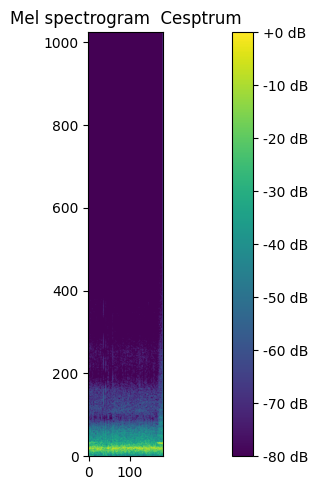

In [20]:
# Plotting example spectrogram
file_path = os.path.join(dir_path, 'noise_spectrogram', '206.npy')
test_spect = np.load(file_path)
test_spect = test_spect[:N, :]

print(test_spect.shape)

plt.figure(figsize=(14, 5))
plt.imshow(test_spect, origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram  Cesptrum')
plt.tight_layout()
plt.show()

In [21]:
# Populating data and labels arrays
non_existant_indices = []
for index, row in data_df.iterrows():
    file_name = str(index) + ".npy"
    
    cat_path = ""
    if row['label'] == 0:
        cat_path = 'noise_spectrogram_2'
    else:
        cat_path = 'orca_spectrogram_2'
    
    file_path = os.path.join(dir_path, cat_path, file_name)
    
    if os.path.exists(file_path):
        spectrogram = np.load(file_path)
        
        if spectrogram.shape[1] > 44:
            print(row)

        # Normalize using std deviation
        spectrogram = normalize_spect(spectrogram)

        # Add spectrogram to data array
        data[index] = spectrogram
        

        # Populate labels array
        labels[index] = row['label'] 
    else:
        non_existant_indices.append(index)

In [22]:
print(len(data))
print(len(labels))
data = np.concatenate((data, aug_orca_data))
labels = np.concatenate((labels, aug_labels))

print(len(data))
print(len(labels))
data_tensor = torch.tensor(data)
labels_tensor = torch.tensor(labels, dtype=torch.long)

21821
21821
35867
35867


In [23]:
labels_tensor = labels_tensor.long()

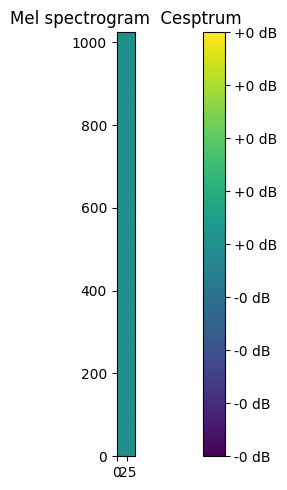

In [24]:
plt.figure(figsize=(14, 5))
plt.imshow(data[1][0], origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram  Cesptrum')
plt.tight_layout()
plt.show()

## Shuffle and split data

In [25]:
# Make the data a OrcaDataSet
custom_dataset = OrcaDataSet(data_tensor, labels_tensor, 2)

# first split train+val
# Determine the size of the training set
train_size = int(train_split/100 * len(custom_dataset)) # 80% of the data set
val_size = int(val_split/100 * len(custom_dataset)) # 10% of the data set
test_size = len(custom_dataset) - train_size - val_size # the rest is test
train_dataset, val_dataset = random_split(custom_dataset, [train_size, test_size+val_size])
# then split val into val+test
test_dataset, val_dataset = random_split(val_dataset, [test_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

In [26]:
print(len(train_loader),len(val_loader),len(test_loader))

224 28 28


## Training and Testing Models

In [27]:
model = OrcaCNN(num_classes=2, num_channels=num_channels,dropout_rate=dropout).to(device)

loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy = train_model(model,
    train_loader,val_loader,test_loader,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation=True)

/tmp/ipykernel_450689/3778550383.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.tensor(sample_labels).float()


[Epoch 1] loss: 0.122 - accuracy: 97.349
[Epoch 2] loss: 0.089 - accuracy: 97.349
[Epoch 3] loss: 0.088 - accuracy: 97.349
[Epoch 4] loss: 0.086 - accuracy: 97.349
[Epoch 5] loss: 0.083 - accuracy: 97.349
[Epoch 6] loss: 0.073 - accuracy: 97.377
[Epoch 7] loss: 0.062 - accuracy: 97.321
[Epoch 8] loss: 0.065 - accuracy: 97.321
[Epoch 9] loss: 0.058 - accuracy: 97.349
[Epoch 10] loss: 0.052 - accuracy: 97.349
[Epoch 11] loss: 0.049 - accuracy: 97.349
[Epoch 12] loss: 0.053 - accuracy: 97.349
[Epoch 13] loss: 0.050 - accuracy: 97.349
[Epoch 14] loss: 0.066 - accuracy: 97.349
[Epoch 15] loss: 0.051 - accuracy: 97.349
[Epoch 16] loss: 0.042 - accuracy: 97.712
[Epoch 17] loss: 0.041 - accuracy: 98.828
[Epoch 18] loss: 0.039 - accuracy: 99.051
[Epoch 19] loss: 0.038 - accuracy: 98.968
[Epoch 20] loss: 0.037 - accuracy: 98.298
[Epoch 21] loss: 0.073 - accuracy: 97.349
[Epoch 22] loss: 0.060 - accuracy: 97.349
[Epoch 23] loss: 0.047 - accuracy: 98.744
[Epoch 24] loss: 0.041 - accuracy: 98.717
[

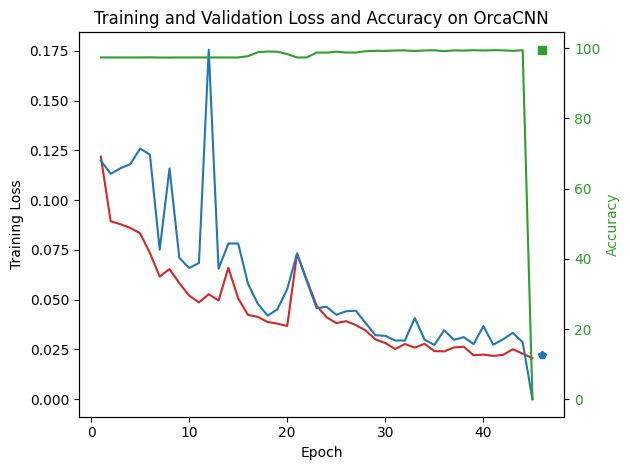

In [28]:
# Plot the results

NN = np.count_nonzero(loss_time)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.plot(np.arange(1, NN+1), loss_time[:NN], color='tab:red')
ax1.plot(np.arange(1, NN+1), val_loss_time[:NN], color='tab:blue')
ax1.plot(NN+1, test_loss, 'p', color='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.plot(np.arange(1, NN+1), val_accuracy_time[:NN], color='tab:green')
ax2.plot(NN+1, test_accuracy, 's', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.title("Training and Validation Loss and Accuracy on OrcaCNN")
fig.tight_layout()
plt.show()
# plt.savefig("OrcaCNN.png")